# **Waze Project**
## Survival curves

In [2]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import pairwise_logrank_test
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [3]:
df = pd.read_csv('dataset_encoded_features.csv')

In [4]:
IS_CHURNED_COL = 'is_churned'

#### Let's take a look at the correlation matrix to avoid choosing correlated the features

In [5]:
df.drop(columns=['ID', 'Unnamed: 0.1', 'Unnamed: 0', 'is_churned','device_code']).corr()

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day,drives_per_driving_day,km_per_drive,sessions_per_activity_day
sessions,1.000000,0.996175,0.586930,0.010822,0.000401,0.000973,0.006367,0.002700,0.135786,0.129581,-0.087657,0.421014,-0.421158,0.432413
drives,0.996175,1.000000,0.584298,0.010109,-0.000319,0.003126,0.006572,0.003514,0.136522,0.130343,-0.087422,0.423282,-0.424644,0.430786
total_sessions,0.586930,0.584298,1.000000,0.005068,-0.003240,0.003587,-0.002070,-0.002548,0.072826,0.067608,-0.058243,0.245622,-0.246504,0.251721
n_days_after_onboarding,0.010822,0.010109,0.005068,1.000000,0.005637,-0.010474,-0.004595,-0.012688,-0.010528,-0.008130,0.008359,-0.001540,0.005297,0.006600
total_navigations_fav1,0.000401,-0.000319,-0.003240,0.005637,1.000000,0.001938,-0.012125,0.008218,0.006855,0.003388,-0.006721,0.002240,-0.019385,0.007129
total_navigations_fav2,0.000973,0.003126,0.003587,-0.010474,0.001938,1.000000,0.002325,0.000771,-0.009900,-0.003650,0.012245,0.005224,0.004729,-0.000552
driven_km_drives,0.006367,0.006572,-0.002070,-0.004595,-0.012125,0.002325,1.000000,0.688261,-0.012128,-0.015059,0.378201,0.012676,0.425808,0.009131
duration_minutes_drives,0.002700,0.003514,-0.002548,-0.012688,0.008218,0.000771,0.688261,1.000000,-0.012240,-0.014819,0.262745,0.007772,0.290745,0.005831
activity_days,0.135786,0.136522,0.072826,-0.010528,0.006855,-0.009900,-0.012128,-0.012240,1.000000,0.939747,-0.512588,-0.442113,-0.228770,-0.429894
driving_days,0.129581,0.130343,0.067608,-0.008130,0.003388,-0.003650,-0.015059,-0.014819,0.939747,1.000000,-0.531219,-0.464449,-0.217580,-0.393085


In [12]:
def plot_surv_curve_for_population(datasource: DataFrame, column: str) -> None:
    kmf = KaplanMeierFitter()
    T = datasource[column]
    C = datasource[IS_CHURNED_COL].astype(float)
    kmf.fit(T, C)
    ax = kmf.plot(title='Kaplan-Meier Survival Curve: Population level')
    ax.set_xlabel(column)


def plot_surv_curve_for_two_os(datasource: DataFrame, column: str) -> None:
    ax = plt.subplot(111)
    And = datasource[datasource['device_code'] == 2]
    iph = datasource[datasource['device_code'] == 1]
    kmf = KaplanMeierFitter()
    
    # fit android
    T = And[column]
    #True if the the death was observed
    C = And[IS_CHURNED_COL].astype(float)
    kmf.fit(T, C)
    ax = kmf.plot(title='Kaplan-Meier Survival Curve', label = "Android")
    # fit iphone
    T = iph[column]
    C = iph[IS_CHURNED_COL].astype(float)
    kmf.fit(T, C)
    kmf.plot(title='Kaplan-Meier Survival Curve',label = "iPhone", ax=ax)
    ax.set_xlabel(column)
    ax.figure.savefig('os_surv_curve_drives.png', transparent=True)

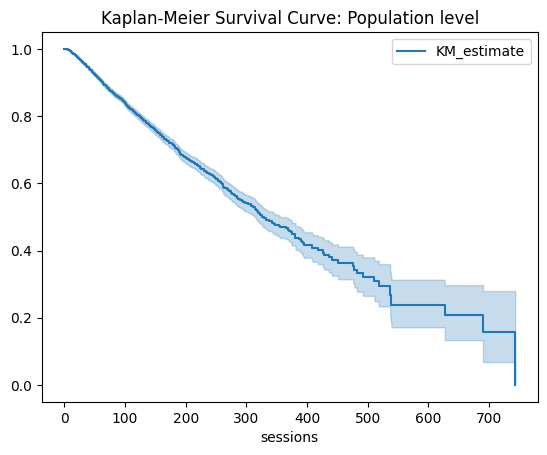

In [40]:
plot_surv_curve_for_population(df, 'sessions')

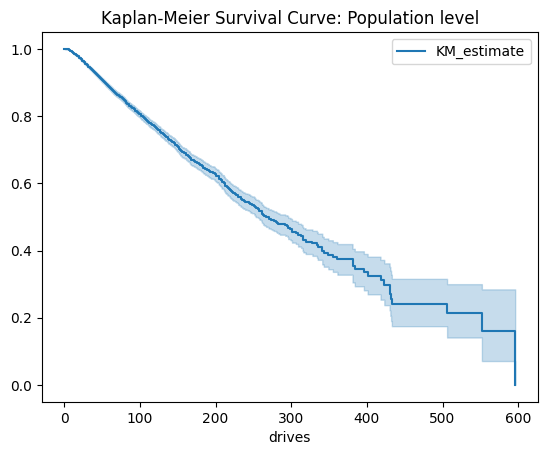

In [8]:
plot_surv_curve_for_population(df, 'drives')

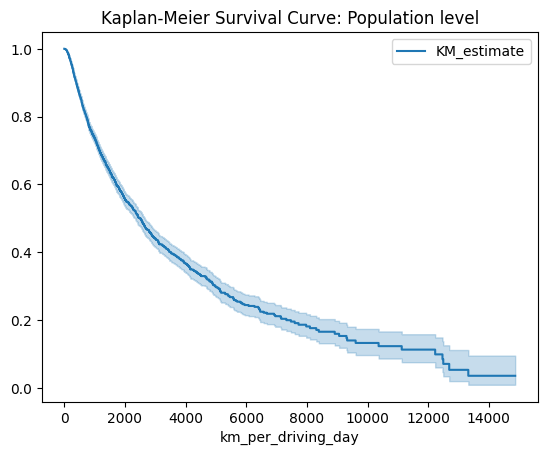

In [42]:
plot_surv_curve_for_population(df, 'km_per_driving_day')

Seems like the more users use the app and the more they drive, the smaller chances of survival. But there curves are not particularly insightful, still

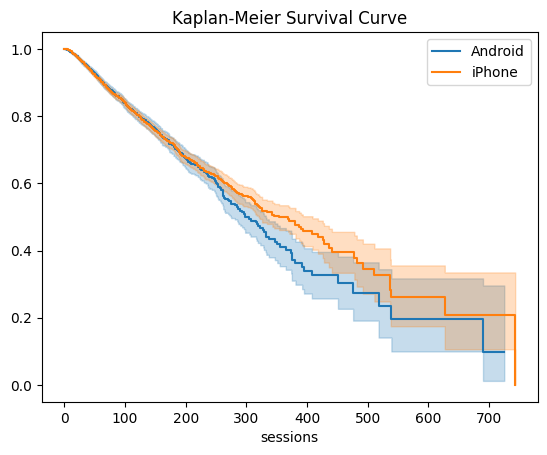

In [45]:
plot_surv_curve_for_two_os(df, 'sessions')

FileNotFoundError: [Errno 2] No such file or directory: '/illustrations/os_surv_curve_drives.png'

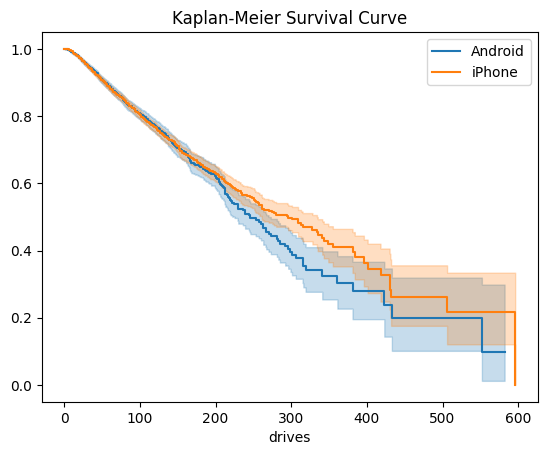

In [13]:
plot_surv_curve_for_two_os(df, 'drives')

Churn rate is almost exactly similar for users of the two OSes till around 250 sessions (~8 sessions per day every day of the month, which is quite a lot) Android users have a worse survival rate on the range of session between 250 to 650, which might indicate that Android app is less convenient to use?

The curves are similar for the `drives` (which is expected since `sessions` and `drives` ar hi), with the starting point of divergence being around 200 drives. 

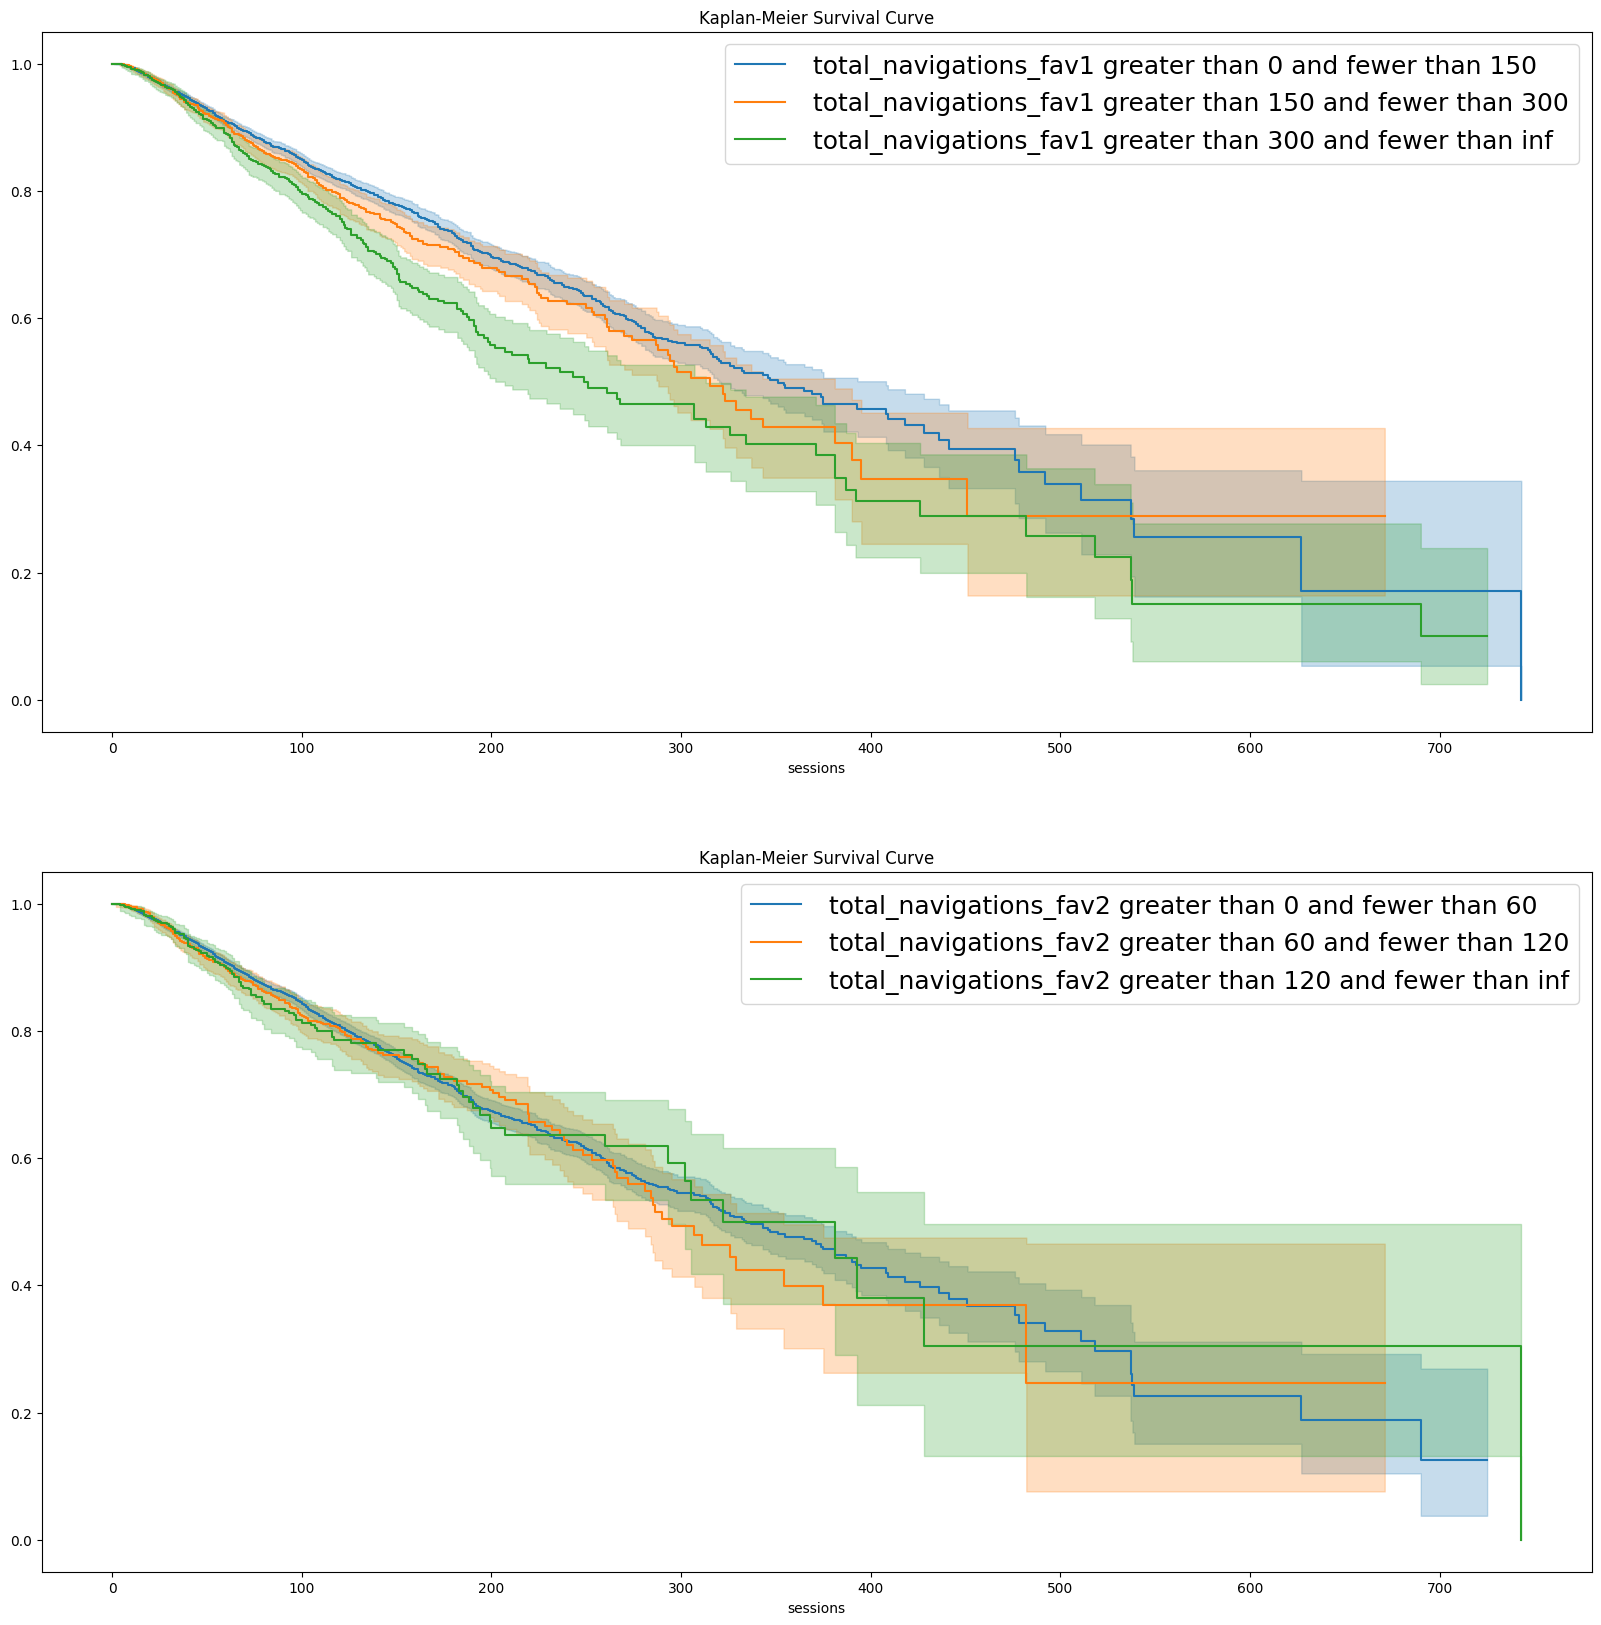

In [12]:
def plot_survival_curves(column_name, values, ax, df):
    values.insert(0,0)
    values.insert(len(values),np.infty)
    values = [[values[i],values[i+1]] for i in range(len(values)-1)]
    for val in values:
        dfr = df[df[column_name] >= val[0]]
        dfr = dfr[dfr[column_name] < val[1]]
        kmf = KaplanMeierFitter()
        cat = 'sessions'
        T = dfr[cat]
        C = dfr[IS_CHURNED_COL].astype(float)
        kmf.fit(T, C)
        kmf.plot(title='Kaplan-Meier Survival Curve', label = f" {column_name} greater than {val[0]} and fewer than {val[1]}", ax=ax)
    ax.legend(title_fontsize=18, fontsize=18)
    ax.set_xlabel(cat)
fig,ax = plt.subplots(2,1,figsize=(20, 20))
column_name = 'total_navigations_fav1'
values = [150, 300]
plot_survival_curves(column_name, values, ax[0], df)
column_name = 'total_navigations_fav2'
values = [60, 120]
plot_survival_curves(column_name, values, ax[1], df)

We see that a client is more likely to churn the more often they navigate to their preferred location. The churn rate is unaffected by the number of visits to the second preferred location

## Conclusion

* Android users seem to have lower survival probabilities after 200 drives than iPhone users
* `total_navigations_fav1` also seems to have explanatory power in terms of churn, unlike `total_navigations_fav2`

These finding may prove useful in the later stages